This notebook explores the efficiency of the different methods of computation of the halo concentration. It compares those methods on semi-analytical halos and test their limits in term of the number of particles

# Load libraries


In [1]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from semi_analytical_halos.density_profile import Profile

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [3]:
from semi_analytical_halos.generate_smooth_halo import Smooth_halo
from semi_analytical_halos.density_profile import Profile
from concentration_accumulation import Concentration_accumulation

# smooth halo

N_tot = 10000


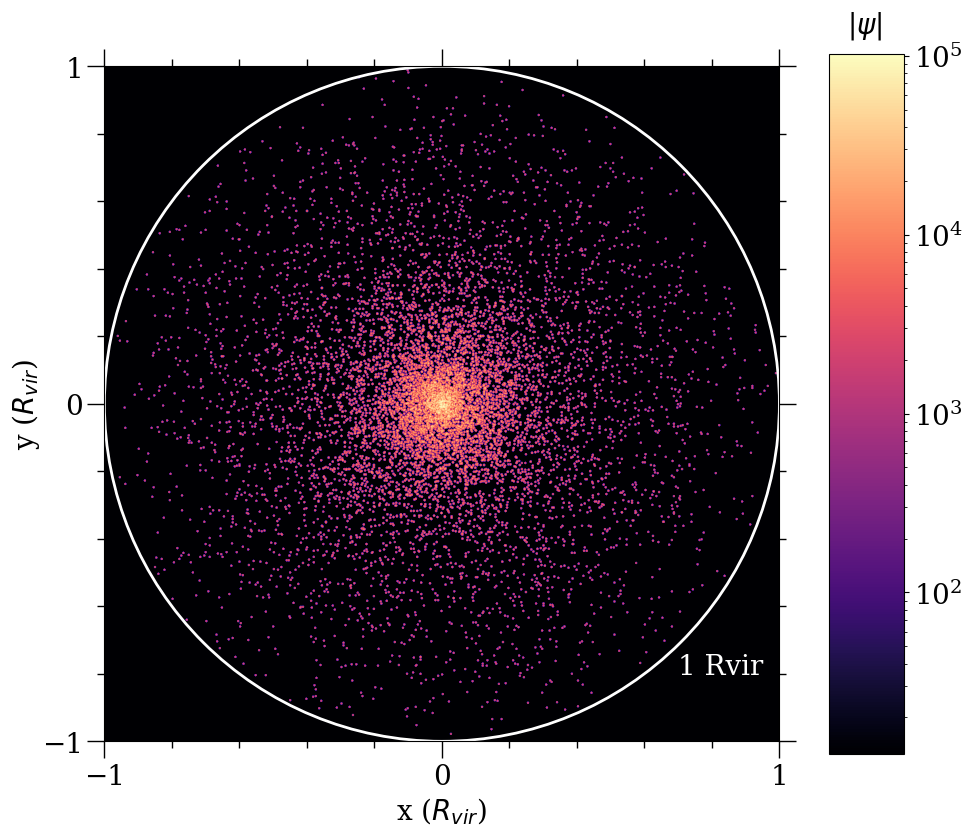

()

In [4]:
halo = Smooth_halo()
kind_profile = {"kind of profile": "abg",
                "concentration": 10,
                "alpha": 1, "beta": 3, "gamma": 1}
my_halo = halo.smooth_halo_creation() #kind_profile, b_ax=0.5, c_ax=0.5)
data = my_halo["data"]
print("N_tot =",my_halo["N_tot"])
#halo.plot_data(data[:,0],data[:,1])
halo.beauty_plot_colorbar(data)

# How to test the concentration computation methods

In [5]:
c_comp = Concentration_accumulation()
profile = Profile()
def build_list(wl_arr, pol_arr):
    my_list = []
    for w in wl_arr:
        for p in pol_arr:
            if p < w:
                my_list += [[w,p]]
    return my_list

def test_many_computation(box_arr, wl_arr, pol_arr, N_times, N_part, N_bin):
    wl_pol = build_list(wl_arr, pol_arr)
    c_acc = np.zeros((N_times))
    c_peak, dc_peak = np.zeros((N_times, len(box_arr))), np.zeros((N_times, len(box_arr)))
    c_peak_sg, dc_peak_sg = np.zeros((N_times, len(wl_pol))), np.zeros((N_times, len(wl_pol)))
    for t in range(N_times):
        my_halo = halo.smooth_halo_creation(N_part=N_part, N_bin=N_bin) #kind_profile, b_ax=0.5, c_ax=0.5)
        data = my_halo["data"]
        r_data = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)
        c_acc[t], ok = c_comp.compute_c_NFW_acc(r_data)
        if ok == False:
            print(ok, c_acc[t])
        out = profile.profile_log_r_bin_hist(r_data, N_bin=N_bin)
        r_log_bin, rho_log_bin, N_part_in_shell = out
        rho_r2 = rho_log_bin * r_log_bin**2
        for b, box in enumerate(box_arr):
            rho_r2_smooth = c_comp.smooth(rho_r2, box)
            c = c_comp.get_c_from_smooth_data(rho_r2_smooth, r_log_bin)
            c_peak[t:t+1,b:b+1], dc_peak[t:t+1,b:b+1] = c[0][0], c[0][1]
        for e, wp in enumerate(wl_pol):
            rho_r2_smooth = savgol_filter(rho_r2, window_length=wp[0], polyorder=wp[1])
            c = c_comp.get_c_from_smooth_data(rho_r2_smooth, r_log_bin)
            c_peak_sg[t:t+1, e:e+1], dc_peak_sg[t:t+1, e:e+1] = c[0][0], c[0][1]
            
    col, dc_col = [], []
    for b in range(len(box_arr)):
        col += ["c_box_"+str(box_arr[b])]
        dc_col += ["dc_box_"+str(box_arr[b])]
    c_peak = pd.DataFrame(c_peak, columns=col)
    dc_peak = pd.DataFrame(dc_peak, columns=dc_col)
    ################
    col, dc_col = [], []
    for wp in wl_pol:
        col += ["c_wl_"+str(wp[0])+"_pol_"+str(wp[1])]
        dc_col += ["dc_wl_"+str(wp[0])+"_pol_"+str(wp[1])]
    c_peak_sg = pd.DataFrame(c_peak_sg, columns=col)
    dc_peak_sg = pd.DataFrame(dc_peak_sg, columns=dc_col)

    return c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg



In [6]:
def do_plot(c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg):
    fig, ax = plt.subplots(nrows=2, figsize=(10,7), sharey=True)
    ax[0].errorbar(range(len(c_peak_sg.mean())),
                   c_peak_sg.mean(), yerr=c_peak_sg.std().values, # + dc_peak_sg.mean().values,
                   fmt="o", label="c_peak_sg")
    ax[0].axhline(10, ls="-", color="r", label="true value")
    ax[0].axhline(np.mean(c_acc), ls="-", color="g", label="c_acc")
    ax[0].axhline(np.mean(c_acc)+np.std(c_acc), ls="--", color="g")
    ax[0].axhline(np.mean(c_acc)-np.std(c_acc), ls="--", color="g")
    ax[0].set_xticks(ticks=range(len(c_peak_sg.mean())),
                     labels=c_peak_sg.columns, rotation=45)
    ax[0].xaxis.tick_top()
    ax[0].set_yticks(ticks=range(8,13))
    ax[0].set_ylim(7,13)
    ax[0].grid(True)
    ax[0].set_ylabel("concentration")
    ax[0].legend()
    ##############################################################################""
    ax[1].errorbar(range(len(c_peak.mean())),
                 c_peak.mean(), yerr=c_peak.std().values, # + dc_peak_sg.mean().values,
                 fmt="o", label="c_peak_conv")
    ax[1].axhline(10, ls="--", color="r", label="true value")
    ax[1].axhline(np.mean(c_acc), ls="-", color="g", label="c_acc")
    ax[1].axhline(np.mean(c_acc)+np.std(c_acc), ls="--", color="g")
    ax[1].axhline(np.mean(c_acc)-np.std(c_acc), ls="--", color="g")
    ax[1].set_xticks(ticks=range(len(c_peak.mean())),
              labels=c_peak.columns, rotation=45)
    ax[1].set_yticks(ticks=range(8,13))
    ax[1].set_ylim(7,13)
    ax[1].grid(True)
    ax[1].set_ylabel("concentration")
    ax[1].legend()
    plt.show()

# Halo with 1000 particles

In [7]:
N_part = 1000
N_bin = 20
N_times = 1000
box_arr = [1, 2, 3, 4, 5]
wl_arr = [2, 3, 4, 5]
pol_arr = [1, 2, 3, 4, 5]
c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg = test_many_computation(box_arr, wl_arr, pol_arr, 
                                                                      N_times, N_part, N_bin)

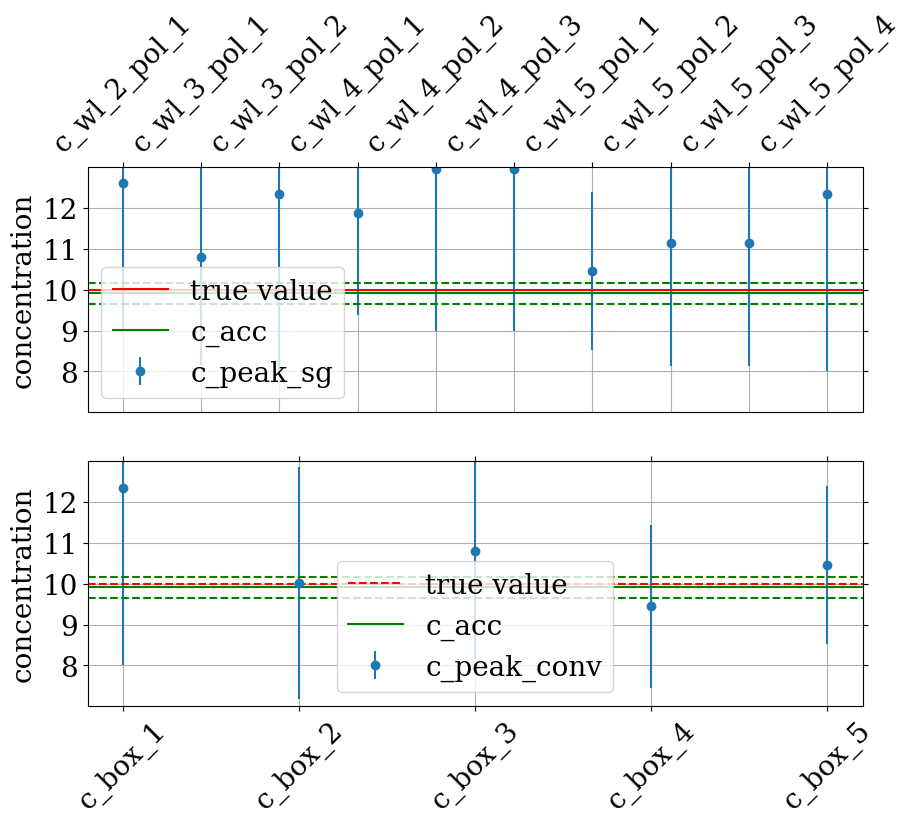

In [8]:
do_plot(c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg)

# Halo with 10000 particles

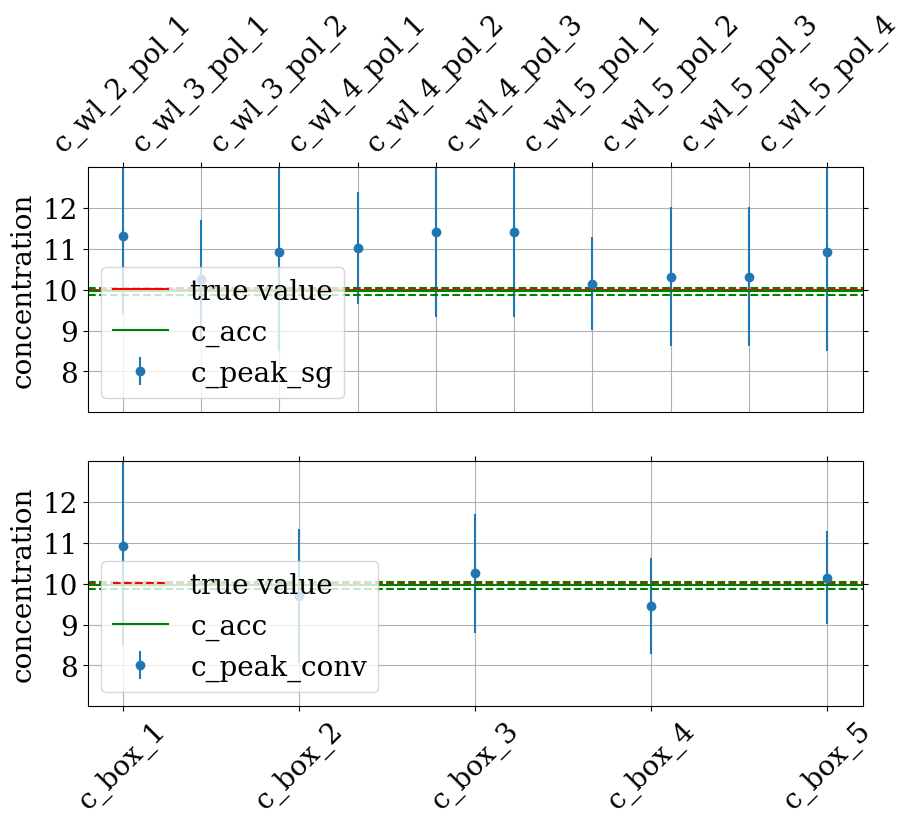

In [9]:
N_part = 10000
N_bin = 30
N_times = 1000
box_arr = [1, 2, 3, 4, 5]
wl_arr = [2, 3, 4, 5]
pol_arr = [1, 2, 3, 4, 5]
c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg = test_many_computation(box_arr, wl_arr, pol_arr, 
                                                                      N_times, N_part, N_bin)
do_plot(c_acc, c_peak, dc_peak, c_peak_sg, dc_peak_sg)